In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#!unzip 'JPEG-Image-Compressor-main.zip'
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [18]:
from collections import Counter

import numpy as np


def zigzag(input_matrix):
    block_size = 8
    z = np.empty([block_size*block_size])
    index = -1
    bound = 0
    for i in range(0, 2 * block_size - 1):
        if i < block_size:
            bound = 0
        else:
            bound = i - block_size + 1
        for j in range(bound, i - bound + 1):
            index += 1
            if i % 2 == 1:
                z[index] = input_matrix[j, i-j]
            else:
                z[index] = input_matrix[i-j, j]
    return z


def zigzag_reverse(input_matrix):
    block_size = 8
    output_matrix = np.empty([block_size, block_size])
    index = -1
    bound = 0
    for i in range(0, 2 * block_size - 1):
        if i < block_size:
            bound = 0
        else:
            bound = i - block_size + 1
        for j in range(bound, i - bound + 1):
            index += 1
            if i % 2 == 1:
                output_matrix[j, i - j] = input_matrix[index]
            else:
                output_matrix[i - j, j] = input_matrix[index]
    return output_matrix


def trim(array: np.ndarray) -> np.ndarray:
    """
    in case the trim_zeros function returns an empty array, add a zero to the array to use as the DC component
    :param numpy.ndarray array: array to be trimmed
    :return numpy.ndarray:
    """
    trimmed = np.trim_zeros(array, 'b')
    if len(trimmed) == 0:
        trimmed = np.zeros(1)
    return trimmed


def run_length_encoding(array: np.ndarray) -> list:
    """
    finds the intermediary stream representing the zigzags
    format for DC components is <size><amplitude>
    format for AC components is <run_length, size> <Amplitude of non-zero>
    :param numpy.ndarray array: zigzag vectors in array
    :returns: run length encoded values as an array of tuples
    """
    encoded = list()
    run_length = 0
    eob = ("EOB",)

    for i in range(len(array)):
        for j in range(len(array[i])):
            trimmed = trim(array[i])
            if j == len(trimmed):
                encoded.append(eob)  # EOB
                break
            if i == 0 and j == 0:  # for the first DC component
                encoded.append((int(trimmed[j]).bit_length(), trimmed[j]))
            elif j == 0:  # to compute the difference between DC components
                diff = int(array[i][j] - array[i - 1][j])
                if diff != 0:
                    encoded.append((diff.bit_length(), diff))
                else:
                    encoded.append((1, diff))
                run_length = 0
            elif trimmed[j] == 0:  # increment run_length by one in case of a zero
                run_length += 1
            else:  # intermediary steam representation of the AC components
                encoded.append((run_length, int(trimmed[j]).bit_length(), trimmed[j]))
                run_length = 0
            # send EOB
        if not (encoded[len(encoded) - 1] == eob):
            encoded.append(eob)
    return encoded


def get_freq_dict(array: list) -> dict:
    """
    returns a dict where the keys are the values of the array, and the values are their frequencies
    :param numpy.ndarray array: intermediary stream as array
    :return: frequency table
    """
    #
    data = Counter(array)
    result = {k: d / len(array) for k, d in data.items()}
    return result


def find_huffman(p: dict) -> dict:
    """
    returns a Huffman code for an ensemble with distribution p
    :param dict p: frequency table
    :returns: huffman code for each symbol
    """
    # Base case of only two symbols, assign 0 or 1 arbitrarily; frequency does not matter
    if len(p) == 2:
        return dict(zip(p.keys(), ['0', '1']))

    # Create a new distribution by merging lowest probable pair
    p_prime = p.copy()
    a1, a2 = lowest_prob_pair(p)
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[a1 + a2] = p1 + p2

    # Recurse and construct code on new distribution
    c = find_huffman(p_prime)
    ca1a2 = c.pop(a1 + a2)
    c[a1], c[a2] = ca1a2 + '0', ca1a2 + '1'

    return c


def lowest_prob_pair(p):
    # Return pair of symbols from distribution p with lowest probabilities
    sorted_p = sorted(p.items(), key=lambda x: x[1])
    return sorted_p[0][0], sorted_p[1][0]

In [20]:
!pip install dahuffman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


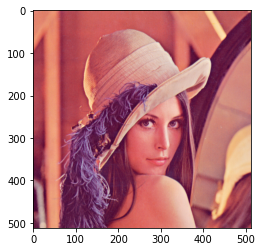

In [19]:
# python 3.9.5
from math import ceil
import matplotlib.pyplot as plt 
import cv2
import numpy as np
from PIL import Image as im

#from functions import *

# define quantization tables
QTY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QTC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])
# define window size
windowSize = len(QTY)

# read image
imgOriginal = cv2.imread('Lenna.png', cv2.IMREAD_COLOR)
imgOriginal = imgOriginal[:,:,::-1]
# convert BGR to YCrCb
img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2YCR_CB)
width = len(img[0])
height = len(img)
y = np.zeros((height, width), np.float32) + img[:, :, 0]
cr = np.zeros((height, width), np.float32) + img[:, :, 1]
cb = np.zeros((height, width), np.float32) + img[:, :, 2]
# size of the image in bits before compression
totalNumberOfBitsWithoutCompression = len(y) * len(y[0]) * 8 + len(cb) * len(cb[0]) * 8 + len(cr) * len(cr[0]) * 8

#plt.imshow(imgOriginal)
#imgOriginal = imgOriginal[:,:,::-1]
plt.imshow(imgOriginal)

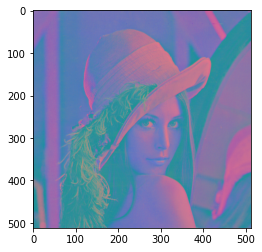

In [ ]:
plt.imshow(img)

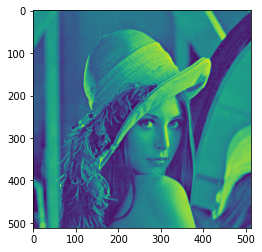

In [ ]:
plt.imshow(y)

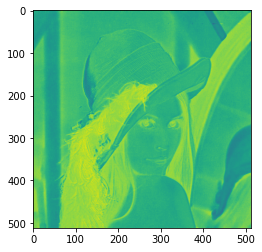

In [ ]:
plt.imshow(cr)

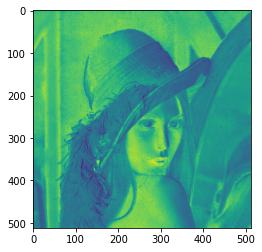

In [ ]:
plt.imshow(cb)

In [ ]:
# channel values should be normalized, hence subtract 128
y = y - 128
cr = cr - 128
cb = cb - 128

# 4: 2: 2 subsampling is used # another subsampling scheme can be used
# thus chrominance channels should be sub-sampled
# define subsampling factors in both horizontal and vertical directions
SSH, SSV = 2, 2
# filter the chrominance channels using a 2x2 averaging filter # another type of filter can be used
# crf = cv2.boxFilter(cr, ddepth=-1, ksize=(2, 2))
# cbf = cv2.boxFilter(cb, ddepth=-1, ksize=(2, 2))

# crSub = crf[::SSV, ::SSH]
# cbSub = cbf[::SSV, ::SSH]

crSub = cr[::SSV, ::SSH]
cbSub = cb[::SSV, ::SSH]


# check if padding is needed,
# if yes define empty arrays to pad each channel DCT with zeros if necessary
yWidth, yLength = ceil(len(y[0]) / windowSize) * windowSize, ceil(len(y) / windowSize) * windowSize
if (len(y[0]) % windowSize == 0) and (len(y) % windowSize == 0):
    yPadded = y.copy()
else:
    yPadded = np.zeros((yLength, yWidth))
    for i in range(len(y)):
        for j in range(len(y[0])):
            yPadded[i, j] += y[i, j]

# chrominance channels have the same dimensions, meaning both can be padded in one loop
cWidth, cLength = ceil(len(cbSub[0]) / windowSize) * windowSize, ceil(len(cbSub) / windowSize) * windowSize
if (len(cbSub[0]) % windowSize == 0) and (len(cbSub) % windowSize == 0):
    crPadded = crSub.copy()
    cbPadded = cbSub.copy()
# since chrominance channels have the same dimensions, one loop is enough
else:
    crPadded = np.zeros((cLength, cWidth))
    cbPadded = np.zeros((cLength, cWidth))
    for i in range(len(crSub)):
        for j in range(len(crSub[0])):
            crPadded[i, j] += crSub[i, j]
            cbPadded[i, j] += cbSub[i, j]



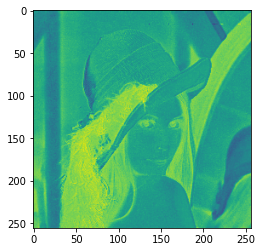

In [ ]:
plt.imshow(crSub)

AttributeError: ignored

In [ ]:
# get DCT of each channel
# define three empty matrices
yDct, crDct, cbDct = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))

# number of iteration on x axis and y axis to calculate the luminance cosine transform values
hBlocksForY = int(len(yDct[0]) / windowSize)  # number of blocks in the horizontal direction for luminance
vBlocksForY = int(len(yDct) / windowSize)  # number of blocks in the vertical direction for luminance
# number of iteration on x axis and y axis to calculate the chrominance channels cosine transforms values
hBlocksForC = int(len(crDct[0]) / windowSize)  # number of blocks in the horizontal direction for chrominance
vBlocksForC = int(len(crDct) / windowSize)  # number of blocks in the vertical direction for chrominance

# define 3 empty matrices to store the quantized values
yq, crq, cbq = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))
# and another 3 for the zigzags
yZigzag = np.zeros(((vBlocksForY * hBlocksForY), windowSize * windowSize))
crZigzag = np.zeros(((vBlocksForC * hBlocksForC), windowSize * windowSize))
cbZigzag = np.zeros(((vBlocksForC * hBlocksForC), windowSize * windowSize))

for i in range(vBlocksForY):
    for j in range(hBlocksForY):
        yDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
            yPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.floor(
            yDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTY + 0.5)
        yZigzag[hBlocksForY*i + j] = zigzag(
            yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])


# either crq or cbq can be used to compute the number of blocks
for i in range(vBlocksForC):
    for j in range(hBlocksForC):
        crDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
            crPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.floor(
            crDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTC + 0.5)
        crZigzag[hBlocksForC*i + j] = zigzag(
            crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        cbDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
            cbPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.floor(
            cbDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTC + 0.5)
        cbZigzag[hBlocksForC* i + j] = zigzag(
            cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
print(yZigzag)
yZigzag = yZigzag.astype(np.int8)
crZigzag = crZigzag.astype(np.int8)
cbZigzag = cbZigzag.astype(np.int8)

[[  7.   1.   1. ...   0.   0.   0.]
 [  5.   2.   1. ...   0.   0.   0.]
 [  3.   1.   1. ...   0.   0.   0.]
 ...
 [-40.   5.   4. ...   0.   0.   0.]
 [-39.  -5.  -2. ...   0.   0.   0.]
 [-27.  -4.  -6. ...   0.   0.   0.]]


[[16. 16. 18. 16. 15.  8. 16. 14.]
 [16. 16. 18. 16. 15.  8. 16. 14.]
 [16. 16. 18. 16. 15.  8. 16. 14.]
 [16. 16. 18. 16. 15.  8. 16. 14.]
 [16. 16. 18. 16. 15.  8. 16. 14.]
 [17. 17.  9.  7. 13. 10. 11. 10.]
 [12. 12. 15. 10. 14. 12. 10.  5.]
 [12. 12.  5.  9. 11. 10.  7.  7.]]


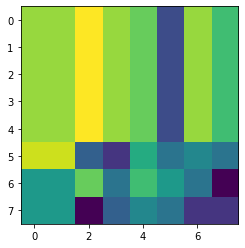

In [ ]:
print(y[0:8, 0:8])
plt.imshow(y[0:8, 0:8])

In [ ]:
print(yDct[0:8, 0:8])

[[ 1.06499992e+02  1.13133621e+01  1.59075928e+00 -3.64716291e+00
   1.49999988e+00  1.18622208e+00 -6.61207008e+00  7.84531021e+00]
 [ 1.46933250e+01 -2.43378803e-01  1.02893758e+00 -9.62945557e+00
   1.56470442e+00  4.63925028e+00 -2.12852287e+00  3.73721623e+00]
 [-7.78333616e+00 -4.88415003e-01 -1.92677665e+00  3.72679472e+00
  -2.14555353e-01 -1.39064956e+00  1.15165019e+00 -2.36435890e+00]
 [ 1.42664921e+00  1.05352223e+00  1.77717841e+00  1.26502454e+00
  -1.19347060e+00 -1.14493942e+00  7.06490278e-02  1.24798942e+00]
 [ 1.00000107e+00 -1.04959071e+00  7.92563036e-02 -2.32947588e+00
   1.99999976e+00  1.25897896e+00 -1.11522138e+00 -1.06624305e+00]
 [ 3.51912796e-01  5.52263260e-01 -2.70151877e+00 -5.91531992e-02
  -2.00014138e+00  5.88528991e-01  1.65807939e+00  1.59641552e+00]
 [-2.45859575e+00 -9.25886631e-03  4.15165043e+00  2.69479132e+00
   1.44186187e+00 -2.29877234e+00 -1.57322335e+00 -1.94987321e+00]
 [ 2.41288972e+00 -1.76997304e-01 -3.09225941e+00 -2.68214440e+00
  -

In [21]:
# find the run length encoding for each channel
# then get the frequency of each component in order to form a Huffman dictionary
from dahuffman import HuffmanCodec

yEncoded = run_length_encoding(yZigzag)
yFrequencyTable = get_freq_dict(yEncoded)
yHuffman = find_huffman(yFrequencyTable)
yHuffman2 = HuffmanCodec.from_frequencies(yFrequencyTable)
print(yHuffman)


crEncoded = run_length_encoding(crZigzag)
crFrequencyTable = get_freq_dict(crEncoded)
crHuffman = find_huffman(crFrequencyTable)

cbEncoded = run_length_encoding(cbZigzag)
cbFrequencyTable = get_freq_dict(cbEncoded)
cbHuffman = find_huffman(cbFrequencyTable)

# calculate the number of bits to transmit for each channel
# and write them to an output file
file = open("CompressedImage.asfh", "w")
yBitsToTransmit = str()
for value in yEncoded:
    yBitsToTransmit += yHuffman[value]

crBitsToTransmit = str()
for value in crEncoded:
    crBitsToTransmit += crHuffman[value]

cbBitsToTransmit = str()
for value in cbEncoded:
    cbBitsToTransmit += cbHuffman[value]

if file.writable():
    file.write(yBitsToTransmit + "\n" + crBitsToTransmit + "\n" + cbBitsToTransmit)
file.close()

totalNumberOfBitsAfterCompression = len(yBitsToTransmit) + len(crBitsToTransmit) + len(cbBitsToTransmit)
print(
    "Compression Ratio is " + str(
        np.round(totalNumberOfBitsWithoutCompression / totalNumberOfBitsAfterCompression, 1)))

{(0, 1, 1): '100', (0, 1, -1): '101', ('EOB',): '011', (0, 2, -2): '0010', (0, 2, 2): '11110', (1, 1, 1): '11100', (1, 1, -1): '11010', (0, 2, -3): '00110', (0, 2, 3): '00010', (2, 1, -1): '111110', (2, 1, 1): '111010', (0, 3, -4): '010111', (0, 3, 4): '010010', (3, 1, -1): '010001', (3, 1, 1): '000011', (1, -1): '000000', (1, 0): '1111110', (0, 3, -5): '1110110', (0, 3, 5): '1101110', (1, 1): '1101101', (4, 1, -1): '1100100', (1, 2, -2): '1100010', (1, 2, 2): '1100000', (2, 2): '0101101', (0, 3, -6): '0101010', (4, 1, 1): '0101001', (2, 3): '0100111', (0, 3, 6): '0100000', (3, 4): '0001110', (5, 1, -1): '0001101', (2, -2): '0000101', (5, 1, 1): '0000010', (0, 3, -7): '11101110', (0, 4, -8): '11001110', (3, 5): '11001101', (0, 3, 7): '11001011', (6, 1, 1): '11000110', (0, 4, 8): '01010110', (6, 1, -1): '01000011', (2, -3): '00111100', (0, 4, 9): '00111010', (3, 6): '00111000', (0, 4, -9): '00111001', (3, 7): '00011001', (2, 2, 2): '00001001', (1, 2, -3): '00000110', (1, 2, 3): '1111111

In [22]:
print()

In [ ]:
_yq, _crq, _cbq = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))
_yDct, _crDct, _cbDct = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))
_yPadded, _crPadded, _cbPadded = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))

for i in range(vBlocksForY):
    for j in range(hBlocksForY):
        _yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = zigzag_reverse(
            yZigzag[hBlocksForY*i + j])
        _yDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = (
            QTY * _yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        _yPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = (cv2.idct(
            _yDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize]))

for i in range(vBlocksForC):
    for j in range(hBlocksForC):
        _crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = zigzag_reverse(
            crZigzag[hBlocksForC*i + j])
        _crDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = (
            QTC * _crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        _crPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = (cv2.idct(
            _crDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize]))
        _cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = zigzag_reverse(
            cbZigzag[hBlocksForC*i + j])
        _cbDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = (
            QTC * _cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
        _cbPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = (cv2.idct(
            _cbDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize]))

# _yPadded = _yPadded + 128
# _crPadded = _crPadded + 128
# _cbPadded = _cbPadded + 128

# _yPadded = _yPadded.astype(np.uint8)
# _crPadded = _crPadded.astype(np.uint8)
# _cbPadded = _cbPadded.astype(np.uint8)

In [ ]:
_yPaddedHeight = int(_yPadded.shape[0] / 2)
_yPaddedWidth = int(_yPadded.shape[1] / 2)
_cr = np.zeros((_yPaddedHeight*2, _yPaddedWidth*2))
_cb = np.zeros((_yPaddedHeight*2, _yPaddedWidth*2)) 

_y = _yPadded
for i in range(_yPaddedHeight):
    for j in range(_yPaddedWidth):
        _cr[2*i, 2*j] = _crPadded[i,j]
        _cr[2*i, 2*j+1] = _crPadded[i,j]
        _cr[2*i+1, 2*j] = _crPadded[i,j]
        _cr[2*i+1, 2*j+1] = _crPadded[i,j]
        _cb[2*i, 2*j] = _cbPadded[i,j]
        _cb[2*i, 2*j+1] = _cbPadded[i,j]
        _cb[2*i+1, 2*j] = _cbPadded[i,j]
        _cb[2*i+1, 2*j+1] = _cbPadded[i,j]

y = y + 128
cr = cr + 128
cb = cb + 128
_y = _y + 128
_cr = _cr + 128
_cb = _cb + 128
_y = _y.astype(np.uint8)
_cr = _cr.astype(np.uint8)
_cb = _cb.astype(np.uint8)
_y = _y[:height, :width]
_cr = _cr[:height, :width]
_cb = _cb[:height, :width]

[[144. 144. 146. ... 150. 134. 108.]
 [144. 144. 146. ... 150. 134. 108.]
 [144. 144. 146. ... 150. 134. 108.]
 ...
 [ 38.  38.  44. ...  88.  82.  80.]
 [ 39.  39.  48. ...  85.  87.  89.]
 [ 39.  39.  48. ...  85.  87.  89.]]


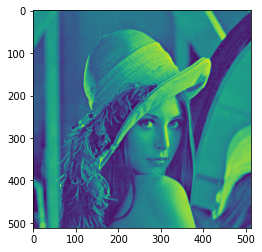

In [ ]:
plt.imshow(y)
print(y)

[[139 144 147 ... 148 130 102]
 [141 145 147 ... 146 129 104]
 [143 146 147 ... 149 134 113]
 ...
 [ 39  40  42 ...  86  83  81]
 [ 38  39  41 ...  85  85  84]
 [ 38  39  41 ...  85  85  86]]


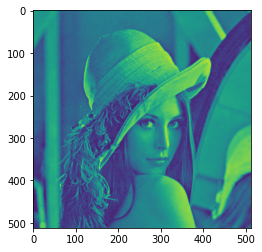

In [ ]:
plt.imshow(_y)
print(_y)

[[114. 114. 119. ... 108. 111. 115.]
 [114. 114. 119. ... 108. 111. 115.]
 [114. 114. 119. ... 108. 111. 115.]
 ...
 [144. 144. 138. ... 125. 124. 127.]
 [141. 141. 138. ... 124. 124. 122.]
 [141. 141. 138. ... 124. 124. 122.]]


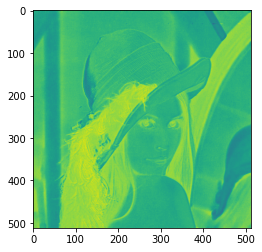

In [ ]:
plt.imshow(cr)
print(cr)

[[114 114 114 ... 105 103 103]
 [114 114 114 ... 105 103 103]
 [113 113 113 ... 111 110 110]
 ...
 [138 138 138 ... 127 126 126]
 [138 138 138 ... 126 125 125]
 [138 138 138 ... 126 125 125]]


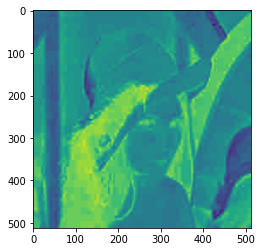

In [ ]:
plt.imshow(_cr)
print(_cr)

[[174. 174. 171. ... 173. 177. 180.]
 [174. 174. 171. ... 173. 177. 180.]
 [174. 174. 171. ... 173. 177. 180.]
 ...
 [154. 154. 155. ... 176. 179. 183.]
 [152. 152. 155. ... 181. 181. 182.]
 [152. 152. 155. ... 181. 181. 182.]]


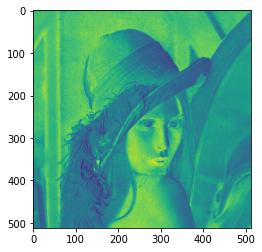

In [ ]:
plt.imshow(cb)
print(cb)

[[173 173 173 ... 172 171 171]
 [173 173 173 ... 172 171 171]
 [174 174 174 ... 172 171 171]
 ...
 [155 155 155 ... 175 179 179]
 [155 155 155 ... 176 180 180]
 [155 155 155 ... 176 180 180]]


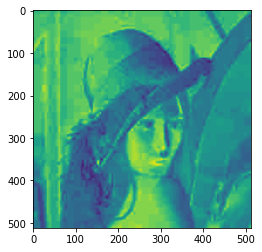

In [ ]:
plt.imshow(_cb)
print(_cb)

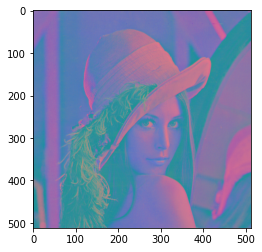

In [ ]:
ycbcr = cv2.merge([y.astype(np.uint8), cr.astype(np.uint8), cb.astype(np.uint8)])
plt.imshow(ycbcr)

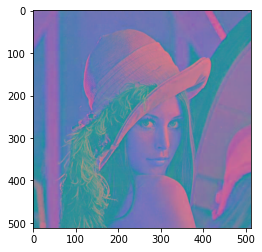

In [ ]:
_ycbcr = cv2.merge([_y.astype(np.uint8), _cr.astype(np.uint8), _cb.astype(np.uint8)])
plt.imshow(_ycbcr)

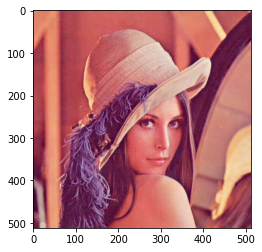

In [ ]:
_img = cv2.cvtColor(_ycbcr, cv2.COLOR_YCR_CB2BGR)
# _img = _img[:,:,::-1]
plt.imshow(_img)

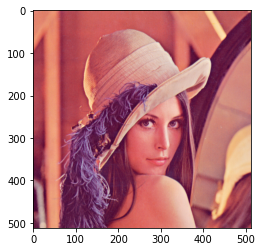

In [ ]:
#imgOriginal = imgOriginal[:,:,::-1]
plt.imshow(imgOriginal)

In [ ]:
difference_array = np.subtract(_img, imgOriginal)
squared_array = np.square(difference_array)
mse = squared_array.mean()
print(mse)

32.20189921061198


In [ ]:
print(yDct[0])

[ 1.06499992e+02  1.13133621e+01  1.59075928e+00 -3.64716291e+00
  1.49999988e+00  1.18622208e+00 -6.61207008e+00  7.84531021e+00
  8.38749924e+01  2.03121052e+01  4.83196163e+00  3.24622774e+00
 -9.37499905e+00  1.27220554e+01  2.19280529e+00 -7.20014763e+00
  5.32499962e+01  1.41051626e+01 -5.63894749e+00 -1.11581459e+01
  4.21468478e-08  2.66588593e+00  2.06513047e+00 -1.95145297e+00
  4.73750000e+01 -5.08835375e-01  9.36248684e+00  3.38598156e+00
 -3.75000060e-01 -1.04833260e+01 -3.20157433e+00  8.91984177e+00
  7.78750000e+01 -2.74132099e+01  3.44614196e+00  1.37501419e+00
  3.12500000e+00 -9.87965965e+00  2.76683092e+00 -1.38863192e+01
  1.68000000e+02 -2.25495968e+01 -8.36415863e+00  6.30126143e+00
 -2.49999985e-01  4.11161995e+00 -5.94422698e-01 -3.12718916e+00
  1.39750000e+02  3.50342140e+01 -1.38445930e+01  3.40995312e+00
  3.75000000e+00 -2.00807806e-02 -7.59734213e-01 -1.30038633e+01
 -1.27499992e+02  1.06546219e+02 -1.30792265e+01 -1.79573669e+01
 -1.44999990e+01  4.54818

In [ ]:
print(yq[0])

[  7.   1.   0.   0.   0.   0.   0.   0.   5.   2.   0.   0.   0.   0.
   0.   0.   3.   1.  -1.  -1.   0.   0.   0.   0.   3.   0.   1.   0.
   0.   0.   0.   0.   5.  -2.   0.   0.   0.   0.   0.   0.  11.  -2.
  -1.   0.   0.   0.   0.   0.   9.   3.  -1.   0.   0.   0.   0.   0.
  -8.  10.  -1.  -1.  -1.   0.   0.   0. -23.  -1.   1.   0.  -1.   0.
   0.   0. -20.  -2.   0.   0.   0.   0.   0.   0. -19.   0.   1.   0.
   0.   0.   0.   0. -19.   0.   0.   0.   0.   0.   0.   0. -19.   1.
   0.   0.   0.   0.   0.   0. -16.  -2.   0.   0.   0.   0.   0.   0.
 -13.  -1.  -1.   0.   0.   0.   0.   0. -11.  -1.   1.   0.   0.   0.
   0.   0.  -9.   0.   0.   0.   0.   0.   0.   0.  -8.   1.   0.   0.
   0.   0.   0.   0.  -9.   0.   0.   1.   0.   0.   0.   0.  -8.  -1.
   0.   0.   0.   0.   0.   0.  -8.  -1.  -1.   0.   0.   0.   0.   0.
  -8.   0.   0.   0.   0.   0.   0.   0.  -8.   1.   0.   0.   0.   0.
   0.   0.  -8.   1.   0.   0.   0.   0.   0.   0.  -7.   0.   0.   0.
   0. 

In [ ]:
print(yZigzag[0])

[ 7  1  1 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
